In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn
%matplotlib inline
seaborn.set
pd.plotting.register_matplotlib_converters()
plt.rcParams['figure.figsize']=(14,8)

In [4]:
def gerar_janelas(lista, tam):
    '''(np.array, int) -> np.array, np.array'''
    x, y = [], []
    n = len(lista)
    for i in range(n-tam):
        janela = lista[i:i+tam]
        x.append(janela)
        y.append(lista[i+tam])
    return np.array(x), np.array(y)

## Treinando dados de cotações

In [8]:
# importando o csv das cotações de venda de moeda estrangeira
moeda = "Dolar"
ano_inicial = 2010
dados_csv = pd.read_csv("datasets/cotacao_%s.csv"%(moeda.split()[0].lower()))
dados_csv.tail()

,cotacaoVenda,dataHoraCotacao,tipoBoletim
17846,"5,2643",2020-09-18 10:04:17.311,Abertura
17847,"5,2843",2020-09-18 11:08:17.654,Intermediário
17848,"5,2944",2020-09-18 12:05:18.839,Intermediário
17849,"5,3124",2020-09-18 13:07:46.208,Intermediário
17850,"5,2889",2020-09-18 13:07:46.211,Fechamento


In [9]:
# filtra cotacoes de Fechamento
dados_brutos = dados_csv.loc[dados_csv.tipoBoletim == "Fechamento"]
dados_brutos = dados_brutos.reset_index().drop(["tipoBoletim", "index"], axis=1)
dados_brutos.tail()

,cotacaoVenda,dataHoraCotacao
2687,"5,2984",2020-09-14 13:11:26.344
2688,"5,2728",2020-09-15 13:05:23.52
2689,"5,2532",2020-09-16 13:07:28.885
2690,"5,2593",2020-09-17 13:08:53.951
2691,"5,2889",2020-09-18 13:07:46.211


In [10]:
# Renomear as colunas
dados = dados_brutos.copy()
dados.columns = ["cotacao", "dia"]

# usando apenas o dia e ignorando o horário
dados.dia = pd.to_datetime(dados.dia.str[:10])
dados = dados.set_index("dia")

# convertendo formato da parte decimal
dados.cotacao = pd.to_numeric(dados.cotacao.str.replace(",", "."))

# filtrando períodos
#dados = dados[:"2015-03-01"]
dados.tail()

,cotacao
dia,
2020-09-14,5.2984
2020-09-15,5.2728
2020-09-16,5.2532
2020-09-17,5.2593
2020-09-18,5.2889


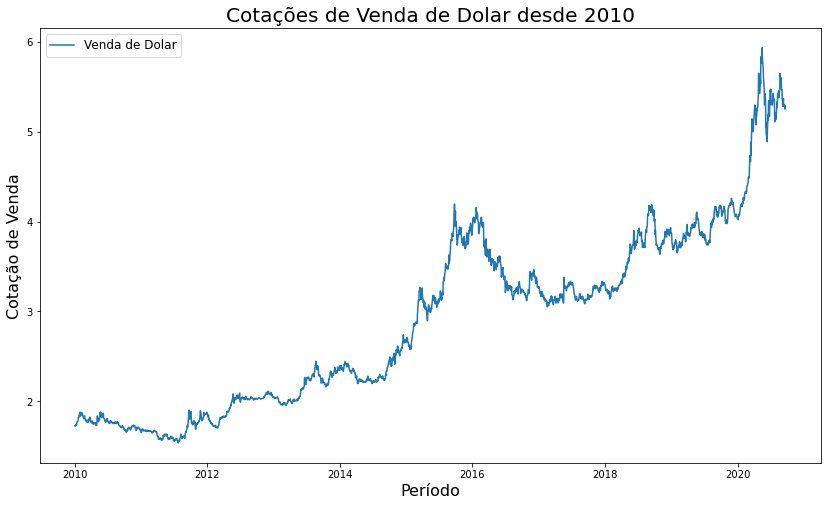

In [11]:
# Exibindo série original
plt.plot(dados, label="Venda de %s"%moeda)
plt.title("Cotações de Venda de %s desde %d"%(moeda, ano_inicial), fontsize=20)
plt.xlabel("Período", fontsize=16)
plt.ylabel("Cotação de Venda", fontsize=16)
plt.legend(fontsize=12)
plt.show()

## Treinamento
Treinar respeitando a ordenação temporal

    Validação: Treino | Teste |
    Previsão:  Treino         | Previsão

In [12]:
train_size = 0.90
train = dados.reset_index().loc[:np.round(dados.shape[0]*train_size), :]
test = dados.reset_index().loc[train.index.max()+1:, :]
train = train.set_index("dia")
test = test.set_index("dia")
# conferindo
print(train.index.max())
print(test.index.min())

2019-08-27 00:00:00
2019-08-28 00:00:00


In [13]:
def plotar_serie(train, test_x, test_y, label=""):
    seaborn.set_style({"axes.grid": False})
    fig, ax = plt.subplots(figsize=(14,7))
    ax.plot(train.index, train.cotacao, "b-")
    ax.set_ylim(1.0, 6.5)
    date_form = DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=30)
    ax2 = ax.twinx()
    ax2.plot(test_x, test_y, "r-.", label=label)
    ax2.set_ylim(1.0, 6.5)
    ax2.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()

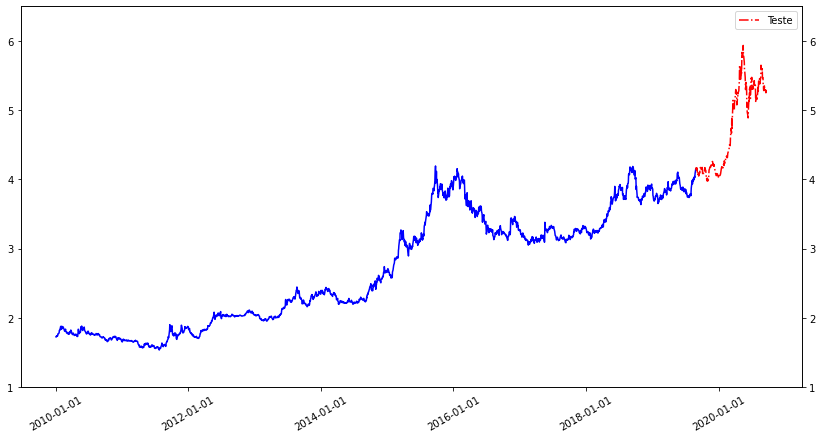

In [14]:
plotar_serie(train, test.index, test.cotacao, "Teste")

In [15]:
tam_janela = 30
x_train, y_train = gerar_janelas(train.cotacao, tam_janela)
x_test, y_test = gerar_janelas(test.cotacao, tam_janela)

print(len(train), "dados de treino =>", len(x_train), "janelas")
print(len(test), "dados de teste =>", len(x_test), "janelas")

for i in range(3):
    print(x[i], y[i])

2424 dados de treino => 2394 janelas
268 dados de teste => 238 janelas
[ 1  2  3  4  5  6  7  8  9 10] 11
[ 2  3  4  5  6  7  8  9 10 11] 12
[ 3  4  5  6  7  8  9 10 11 12] 13


In [16]:
X_train = x_train.reshape((len(x_train), tam_janela, 1))
X_test = x_test.reshape((len(x_test), tam_janela, 1))

In [17]:
# criar modelo
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=5, activation='elu', input_shape=(tam_janela, 1)))
model.add(keras.layers.MaxPooling1D(pool_size=5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='elu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
# treinar modelo
_ = model.fit(X_train, y_train, epochs=50, verbose=0)

# salvar modelo
model.save("keras_dolar.h5")

In [34]:
# carregar modelo
model = keras.models.load_model("keras_dolar.h5")

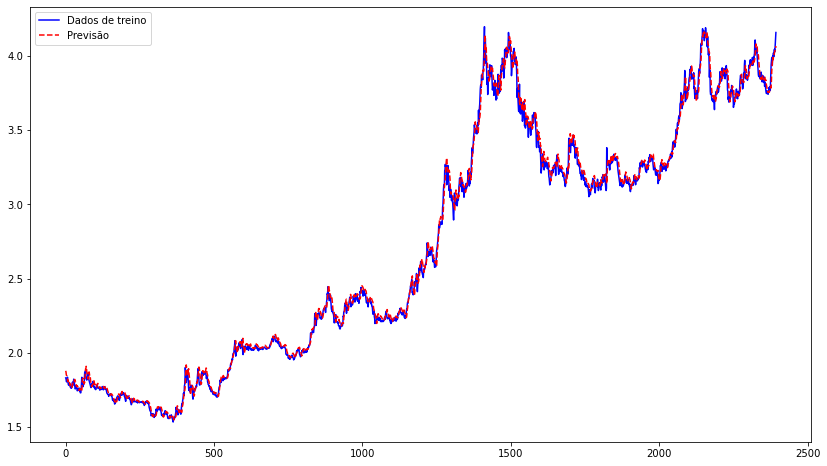

In [57]:
# Plotando previsões versus real do conjunto de treino
y_train_pred = model.predict(X_train).reshape(-1)

plt.plot(y_train, "b-", label="Dados de treino")
plt.plot(y_train_pred, "r--", label="Previsão")
plt.legend(loc=2)
plt.show()

In [36]:
# Exibe erro MSE para conjunto de treino
model.evaluate(X_train, y_train)

75/75 [==============================] - 0s 3ms/step - loss: 0.0020


0.002049271482974291

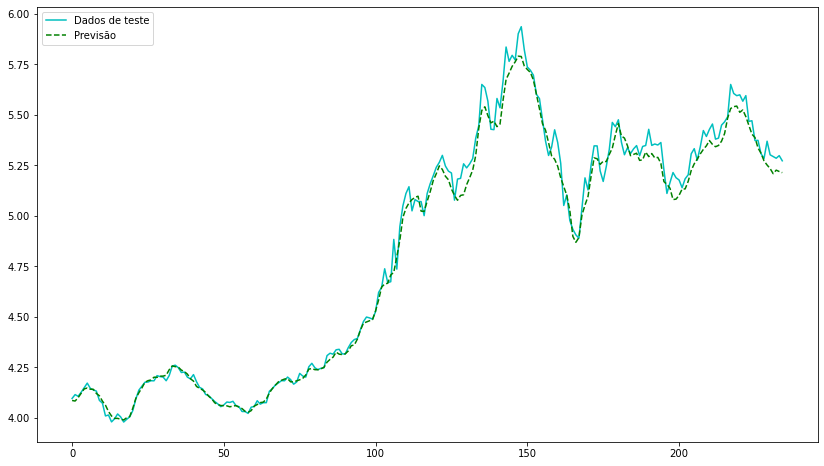

In [60]:
# Plotando previsões versus real do conjunto de teste
y_test_pred = model.predict(X_test).reshape(-1)

plt.plot(y_test[:-3], "c-", label="Dados de teste")
plt.plot(y_test_pred[3:], "g--", label="Previsão")
plt.legend(loc=2)
plt.show()

In [38]:
# Exibe erro MSE para conjunto de treino
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 5ms/step - loss: 0.0141


0.014146021567285061